# Baryonic bahcall model (No dark disk)

In [50]:
%matplotlib notebook
from __future__ import division    #for division operator
import math, numpy as np
from sympy.mpmath import *
from astropy import constants as const
from astropy import units as u
from scipy.integrate import quad, odeint
import matplotlib.pylab as plt
from scipy.optimize import brentq
from scipy.interpolate import InterpolatedUnivariateSpline

infilepath = '/Users/Jatan/Desktop/DDDM/Data/'
outfilepath = '/Users/Jatan/Desktop/DDDM/Plots/No_disk/'

#----------------definitions-------------------------

data_hip_A = infilepath + 'data_AstarsCorr.txt'   
Gal_lat_A, z_coord_A, vel_A = np.loadtxt(data_hip_A, delimiter=",", skiprows=1, usecols=(2, 5, 17), unpack=True)
zsun = 7 #26  #height of the sun (in pc)
z_A = z_coord_A + zsun   # z = z' + zsun  (in pc)
# data_hip_A = infilepath + 'hipparcos_data_Astars.txt'   
# Gal_lat_A, z_coord_A, vel_A = np.loadtxt(data_hip_A, skiprows=2, usecols=(1, 4, 5), unpack=True)
# z_A = z_coord_A*1000 + zsun
lowlat_A_stars = []
for i in range(len(Gal_lat_A)):
	if (abs(Gal_lat_A[i]) < 12):
		lowlat_A_stars.append(i)
vel_z_A = [vel_A[j] for j in lowlat_A_stars]

In [2]:
#Definition of potential is off by a factor of 4 pi G, because this factor has been absorbed into the definition of sigma
G = (const.G.to('pc3 /solMass s2')).value
scaling = (1* u.km).to('pc').value / np.sqrt(8*np.pi*G)
rhoDH_initial = 0.008 #* u.solMass/((u.pc)**3) initial guess for dark halo disk
#index =   [ 0,      1,     2,      3,      4,      5,      6,      7,      8,      9,    10,     11,    12,    13,     14,     15,         16]
rho0_old = [0.021, 0.016, 0.012, 0.0009, 0.0006, 0.0031, 0.0015, 0.0020, 0.0022, 0.007, 0.0135, 0.006, 0.002, 0.0035, 0.0001, rhoDH_initial] #* u.solMass/((u.pc)**3)
sigma_old = [4.0, 7.0, 9.0, 40.0, 20.0, 7.5, 10.5, 14.0, 18.0, 18.5, 18.5, 20.0, 20.0, 37.0, 100.0, 130] #* u.km/u.s
vel_disp_old =[pow(x * scaling, 2) for x in sigma_old]
def func_bary(y, z, rho_dh):
  	y1, y2 = y
  	rho0_old[15] = rho_dh
  	return [y2, sum([x*exp(-y1/(2*y)) for x,y in zip(rho0_old, vel_disp_old)])]

"""Kernel Density Estimation with Scipy"""
from scipy.stats import gaussian_kde
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth, **kwargs) #/ x.std(ddof=1)
    return kde.evaluate(x_grid)

### ODE solver

In [3]:
y0 = [0.0, 0.0] 
z1 = np.linspace(0, 3000, 3000)    
z2 = np.linspace(-3000, -1, 3000)  #note: scipy's interp1d only interpolates for a monotonic array, hence the -0.01 instead of 0; extend to 170pc!
z = np.concatenate((z2, z1), axis=0) 
rhoDH = [rhoDH_initial] 
rhoDH_constrain = 0.008 #* u.solMass/((u.pc)**3)
test_grid = range(3000)

i = 0
for i in range(7):
	sol2 = odeint(func_bary, y0, z1, args=(rhoDH[i],))       #ensure it takes different values 
	sol = np.concatenate((list(reversed(sol2[:,0])), sol2[:,0]), axis=0)      #workaround for obtaining symmetric plot
 	phi = InterpolatedUnivariateSpline(z, sol)

	rhoDH.append(float(rhoDH_constrain / exp(-phi(2500)/(2*vel_disp_old[15]))))
 	i += 1

rescaling = 4*np.pi*G / pow((1* u.km).to('pc').value, 2)   #to obtain phi in km^2/s^2
phi_rescaled = InterpolatedUnivariateSpline(z, rescaling*sol)

print rhoDH
print phi_rescaled(0)

[0.008, 0.010254471380805649, 0.010442971564630497, 0.010458901594606808, 0.010460249019644763, 0.010460362998682202, 0.010460372640259742, 0.010460373455848425]
-1.08420217249e-19


### Constructing observed density of A-stars 

In [29]:
no_of_samples = 100
q = 1/2  						
frac_z_A = int(q*len(z_A))  
zmin, zmax = min(z_A), max(z_A) 
z_grid = []
for i in range(len(z)):
	if zmin <= z[i] <= zmax:
		z_grid.append(z[i])
        
def rho_obs_Astars(no_of_samples, frac, z_trunc, z_A):
    pdf_z_A = []
    Delta_list_z = []
    rho_obs = kde_scipy(z_A, z_trunc, bandwidth='silverman')     #kde for observed A-stars; need to normalize for density!
    z_A_sample = []                                                                                                 
    for i in xrange(no_of_samples):
        z_A_sample.append(np.random.choice(z_A, frac, replace=False))  
    for i in xrange(no_of_samples):
        pdf_z_A.append(kde_scipy(z_A_sample[i], z_trunc, bandwidth='silverman'))  #fix a gaussian kde for each sample to obtain a distribution									
                                                
    for i in xrange(len(z_trunc)):         #create a list of values at a particular z for different sample distributions
        Delta_list_z.append([pdf_z_A[j][i] for j in xrange(no_of_samples)])

    Delta_rho_z =[2*np.std(Delta_list_z[i], ddof=1) for i in xrange(len(z_trunc))]  
    rho_err_max = rho_obs+Delta_rho_z
    rho_err_min = rho_obs-Delta_rho_z
    
    return rho_obs, rho_err_max, rho_err_min, Delta_rho_z

In [5]:
%timeit rho_obs_Astars(no_of_samples, frac_z_A, z_grid, z_A)

1 loops, best of 3: 1.14 s per loop


### Modeling density of A-stars using kinematic information

In [11]:
velmin, velmax = min(vel_z_A), max(vel_z_A)  
vel_grid = np.linspace(velmin, velmax, len(vel_z_A))
frac_vel_A = int(q*len(vel_z_A))
norm_Astars = 0.005151 #* u.solMass/((u.pc)**3)

def rho_f_Astars(no_of_samples, frac, z, vel_z, vel_z_A):
    pdf_vel_A = []
    norm_vel = []
    result = []
    Delta_list_vel = []
    
    vel_A_sample = []
    for i in xrange(no_of_samples):
        vel_A_sample.append(np.random.choice(vel_z_A, frac, replace=False))
    for i in xrange(no_of_samples):
        pdf_vel_A.append(kde_scipy(vel_A_sample[i], vel_z, bandwidth='silverman'))   #pdf_vel_A[i][j] is a 100 x (371) array for A-stars 
    v_mean = [vel_z[np.where(pdf_vel_A[i] == max(pdf_vel_A[i]))[0][0]] for i in xrange(no_of_samples)] #position of max velocity 

    f_w = [InterpolatedUnivariateSpline(vel_z-v_mean[i], pdf_vel_A[i]) for i in xrange(no_of_samples)]
#     def func_vel_check(w, s_i):				  #s_i -> sample index
#         return f_w[s_i](w)  #f_w(w) integrates to 1 (sanity check!)
#     norm_vel.append([quad(func_vel_check, velmin, velmax, args=(j,))[0] for j in xrange(no_of_samples)])

    def func_vel(w, s_i, potential):				  #s_i -> sample index
        return f_w[s_i](np.sqrt(pow(w, 2) + 2*potential))  #f_w(w) integrates to 1 (sanity check!)

    for j in xrange(no_of_samples):
        result.append([quad(func_vel, velmin, velmax, args=(j, phi_rescaled(i)))[0] for i in z])

    for i in xrange(len(z)):
        Delta_list_vel.append([norm_Astars*result[j][i] for j in xrange(no_of_samples)])   
    
    rho_f = [np.average(Delta_list_vel[i]) for i in xrange(len(z))]  #constructed density f, consider mean of all samples
    rho_f_norm = [norm_Astars*rho_f[i]/max(rho_f) for i in xrange(len(rho_f))]
    Delta_rho_vel =[np.std(Delta_list_vel[i], ddof=1) for i in xrange(len(z))]  
    vel_err_max = [(rho_f_norm[i] + Delta_rho_vel[i]) for i in xrange(len(z))]
    vel_err_min = [(rho_f_norm[i] - Delta_rho_vel[i]) for i in xrange(len(z))]
    
    return rho_f_norm, vel_err_max, vel_err_min, Delta_rho_vel

In [ ]:
%timeit rho_f_Astars(no_of_samples, frac_vel_A, z_grid, vel_grid, vel_z_A)

In [12]:
rho_f, rho_f_norm, vel_err_max, vel_err_min, Delta_rho_vel = rho_f_Astars(no_of_samples, frac_vel_A, z_grid, vel_grid, vel_z_A)

In [51]:
rho_obs, rho_err_max, rho_err_min, Delta_rho_z = rho_obs_Astars(no_of_samples, frac_z_A, z_grid, z_A)

In [52]:
chi_sq = np.sum([pow(rho_obs[i] - rho_f_norm[i], 2)/(pow(Delta_rho_z[i], 2) + pow(Delta_rho_vel[i], 2)) for i in xrange(len(z_grid))])
print chi_sq

238.716616577


In [42]:
pow(rho_obs[150] - rho_f_norm[150], 2)/(pow(Delta_rho_z[150], 2) + pow(Delta_rho_vel[150], 2))

0.25128984150254757

### Plotting routine for comparing observed and constructed densities


<IPython.core.display.Javascript object>


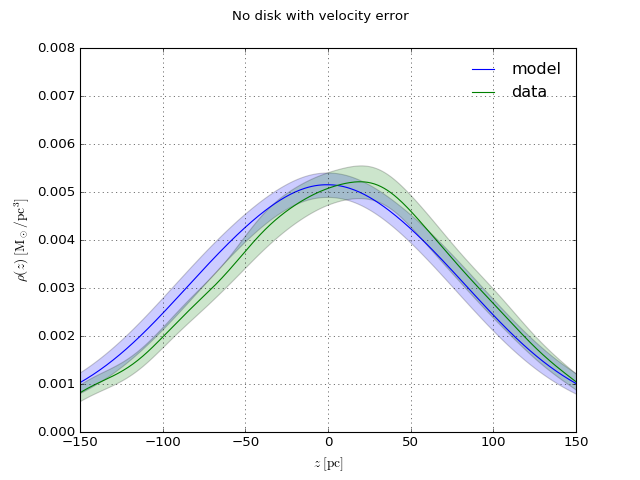

In [55]:
plt.fill_between(z_grid, vel_err_max, vel_err_min, facecolor='b', alpha=0.2)
plt.plot(z_grid, rho_f_norm,'b', label='model')
plt.fill_between(z_grid, rho_err_max, rho_err_min, facecolor='g', alpha=0.2)
plt.plot(z_grid, rho_obs,'g', label='data')
#plt.hist(z_A, bin_list_A, normed = 'True', color='gray', histtype='stepfilled', alpha=0.3)   #normed = 'True'
#plt.plot(z, rho[1],'g', label='HI')
plt.ylabel(r'$\rho(z) \; [ \mathrm{M_\odot/pc^3} ]$')   
plt.xlabel(r'$z \; [ \mathrm{pc} ]$')
plt.xlim(-150, 150)
plt.ylim(0, 0.008)
plt.suptitle(r'No disk with velocity error') 
plt.legend(loc='best', frameon=False)
plt.grid()
plt.savefig(outfilepath + 'rho_no_disk.pdf')

### No velocity error plots

In [ ]:
plt.plot(vel_grid, f_w(vel_grid),'b', label='model')
plt.xlim(-20, 20)
plt.xlabel(r'$w \; [ \rm{km/s} ]$')   
plt.ylabel(r'$f(w) \; [ \rm{(km/s)^{-1}} ]$')
plt.grid()
plt.show()

In [ ]:
plt.plot(z_trunc, rho_f,'b', label='model')
plt.fill_between(z_grid, rho_err_max, rho_err_min, facecolor='g', alpha=0.2)
plt.plot(z_grid, rho_obs,'g', label='data')
#plt.hist(z_A, bin_list_A, normed = 'True', color='gray', histtype='stepfilled', alpha=0.3)   #normed = 'True'
#plt.plot(z, rho[1],'g', label='HI')
plt.ylabel(r'$\rho(z) \; [ \mathrm{M_\odot/pc^3} ]$')   
plt.xlabel(r'$z \; [ \mathrm{pc} ]$')
plt.xlim(-170, 170)
plt.ylim(0, 0.008)
plt.suptitle(r'No dark disk (f(w-w_mean))') 
plt.legend(loc='best', frameon=False)
plt.grid()
plt.savefig(outfilepath + 'rho_no_disk_mean_avg.pdf')  #'multi_component_full.pdf'  #'rho_combined_line.pdf'

In [ ]:
plt.plot(z_trunc, [rho_f[i]/norm_Astars for i in range(len(rho_f))],'b', label='model')
plt.ylabel(r'$\rho(z) \; [ \mathrm{M_\odot/pc^3} ]$')   
plt.xlabel(r'$z \; [ \mathrm{pc} ]$')
plt.xlim(-170, 170)
plt.suptitle(r'') 
plt.legend(loc='best', frameon=False)
plt.grid()
plt.savefig(outfilepath + 'rho_fw.pdf')  #'multi_component_full.pdf'  #'rho_combined_line.pdf'